# Epymorph dev log: June 20th, 2023

_author: Tyler Coles_

_as of git hash: TBD_

In [1]:
from epymorph.ipm_exp import (CompartmentalIpmBuilder, CompartmentModel,
                              CompartmentSymbols, Edge, Fork, Param,
                              validate_model)

# Create model

cs = CompartmentSymbols.create(
    compartments=['S', 'E', 'Ia', 'Ip', 'Is',
                  'Ib', 'Ih', 'Ic1', 'Ic2', 'D', 'R'],
    attributes=[
        Param('beta_1', 'beta_1', shape='S', dtype='float'),
        Param('omega_1', 'omega_1', shape='S', dtype='float'),
        Param('omega_2', 'omega_2', shape='S', dtype='float'),
        Param('delta_1', 'delta_1', shape='S', dtype='float'),
        Param('delta_2', 'delta_2', shape='S', dtype='float'),
        Param('delta_3', 'delta_3', shape='S', dtype='float'),
        Param('delta_4', 'delta_4', shape='S', dtype='float'),
        Param('delta_5', 'delta_5', shape='S', dtype='float'),
        Param('gamma_a', 'gamma_a', shape='S', dtype='float'),
        Param('gamma_b', 'gamma_b', shape='S', dtype='float'),
        Param('gamma_c', 'gamma_c', shape='S', dtype='float'),
        Param('rho_1', 'rho_1', shape='S', dtype='float'),
        Param('rho_2', 'rho_2', shape='S', dtype='float'),
        Param('rho_3', 'rho_3', shape='S', dtype='float'),
        Param('rho_4', 'rho_4', shape='S', dtype='float'),
        Param('rho_5', 'rho_5', shape='S', dtype='float')
    ])

[S, E, Ia, Ip, Is, Ib, Ih, Ic1, Ic2, D, R] = cs.compartments
[beta_1, omega_1, omega_2, delta_1, delta_2, delta_3, delta_4, delta_5,
    gamma_a, gamma_b, gamma_c, rho_1, rho_2, rho_3, rho_4, rho_5] = cs.attributes

N = S + E + Ia + Ip + Is + Ib + Ih + Ic1 + Ic2 + D + R
lambda_1 = (omega_1 * Ia + Ip + Is + Ib + omega_2 * (Ih + Ic1 + Ic2)) / (N - D)

sparsemod_model = CompartmentModel(
    symbols=cs,
    transitions=[
        Edge(S, E, rate=beta_1 * lambda_1 * S),
        Fork([
            Edge(E, Ia, rate=E * delta_1 * rho_1),
            Edge(E, Ip, rate=E * delta_1 * (1 - rho_1))
        ]),
        Edge(Ip, Is, rate=Ip * delta_2),
        Fork([
            Edge(Is, Ib,  rate=Is * delta_3 * (1 - rho_2 - rho_3)),
            Edge(Is, Ih,  rate=Is * delta_3 * rho_2),
            Edge(Is, Ic1, rate=Is * delta_3 * rho_3)
        ]),
        Fork([
            Edge(Ih, Ic1, rate=Ih * delta_4 * rho_4),
            Edge(Ih, R,   rate=Ih * delta_4 * (1 - rho_4))
        ]),
        Fork([
            Edge(Ic1, D,   rate=Ic1 * delta_5 * rho_5),
            Edge(Ic1, Ic2, rate=Ic1 * delta_5 * (1 - rho_5))
        ]),
        Edge(Ia, R,  rate=Ia * gamma_a),
        Edge(Ib, R,  rate=Ib * gamma_b),
        Edge(Ic2, R, rate=Ic2 * gamma_c)
    ])

validate_model(sparsemod_model)

ipm_builder = CompartmentalIpmBuilder(sparsemod_model)

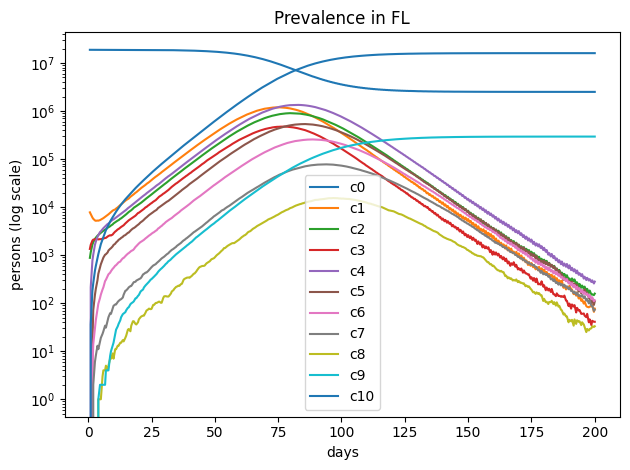

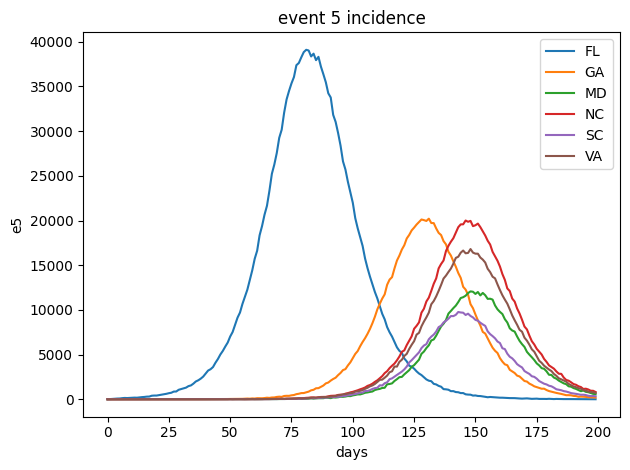

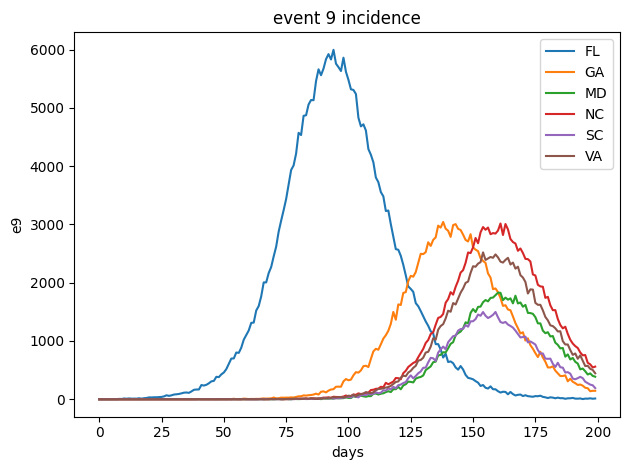

In [2]:
from datetime import date

from epymorph.data import geo_library, mm_library
from epymorph.run import plot_event, plot_pop
from epymorph.simulation import Simulation

# Run simulation

sim = Simulation(
    geo_library['pei'](),
    ipm_builder,
    mm_library['pei']())

out = sim.run(
    param={
        'infection_seed_loc': 0,
        'infection_seed_size': 10000,
        'move_control': 1,
        'theta': 0.1,
        'beta_1': 0.3,
        'omega_1': 0.55,
        'omega_2': 0.05,
        'delta_1': 0.333,
        'delta_2': 0.5,
        'delta_3': 0.166,
        'delta_4': 0.142,
        'delta_5': 0.125,
        'gamma_a': 0.166,
        'gamma_b': 0.333,
        'gamma_c': 0.25,
        'rho_1': 0.4,
        'rho_2': 0.175,
        'rho_3': 0.015,
        'rho_4': 0.2,
        'rho_5': 0.6,
    },
    start_date=date(2015, 1, 1),
    duration_days=200,
)

plot_pop(out, 0) # Florida prevalence

plot_event(out, 5) # 5: Is->Ih: hospitalizations, non-ICU
plot_event(out, 9) # 9: Ic1->D: deaths
